In [1]:
import os
import sys
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])

api_dir = str(curr_dir)
if api_dir not in sys.path:
    sys.path.insert(0, api_dir)

import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.model.classifier import Classifier
from src.xbox2_specific.datasets.XBOX2_trend_all_bd_20ms import XBOX2TrendAllBD20msSelect
from src.utils.dataset_creator import load_dataset

2021-11-10 11:27:15.206627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-10 11:27:15.206643: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Train model on data
Before using explainable AI we need to have a trained model.
To get more insight in this step see the `modeling_example` notebook.

In [2]:
#Load data
train_runs = [2, 4, 5, 6, 8, 9]
valid_runs = [1, 7]
test_runs = [3]

path_to_data = Path("/eos/project/m/ml-for-alarm-system/private/CLIC_data_transfert/Xbox2_hdf_new2/")

train, valid, test = load_dataset(creator=XBOX2TrendAllBD20msSelect(),
                                  data_path=path_to_data,
                                  manual_split=(train_runs, valid_runs, test_runs),
                                  manual_scale=[1, 2, 3, 4, 5, 6, 7, 8, 9])

2021-11-10 11:48:44.226863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-10 11:48:44.252410: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-10 11:48:44.264727: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hsb-cern): /proc/driver/nvidia/version does not exist
2021-11-10 11:48:44.578682: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


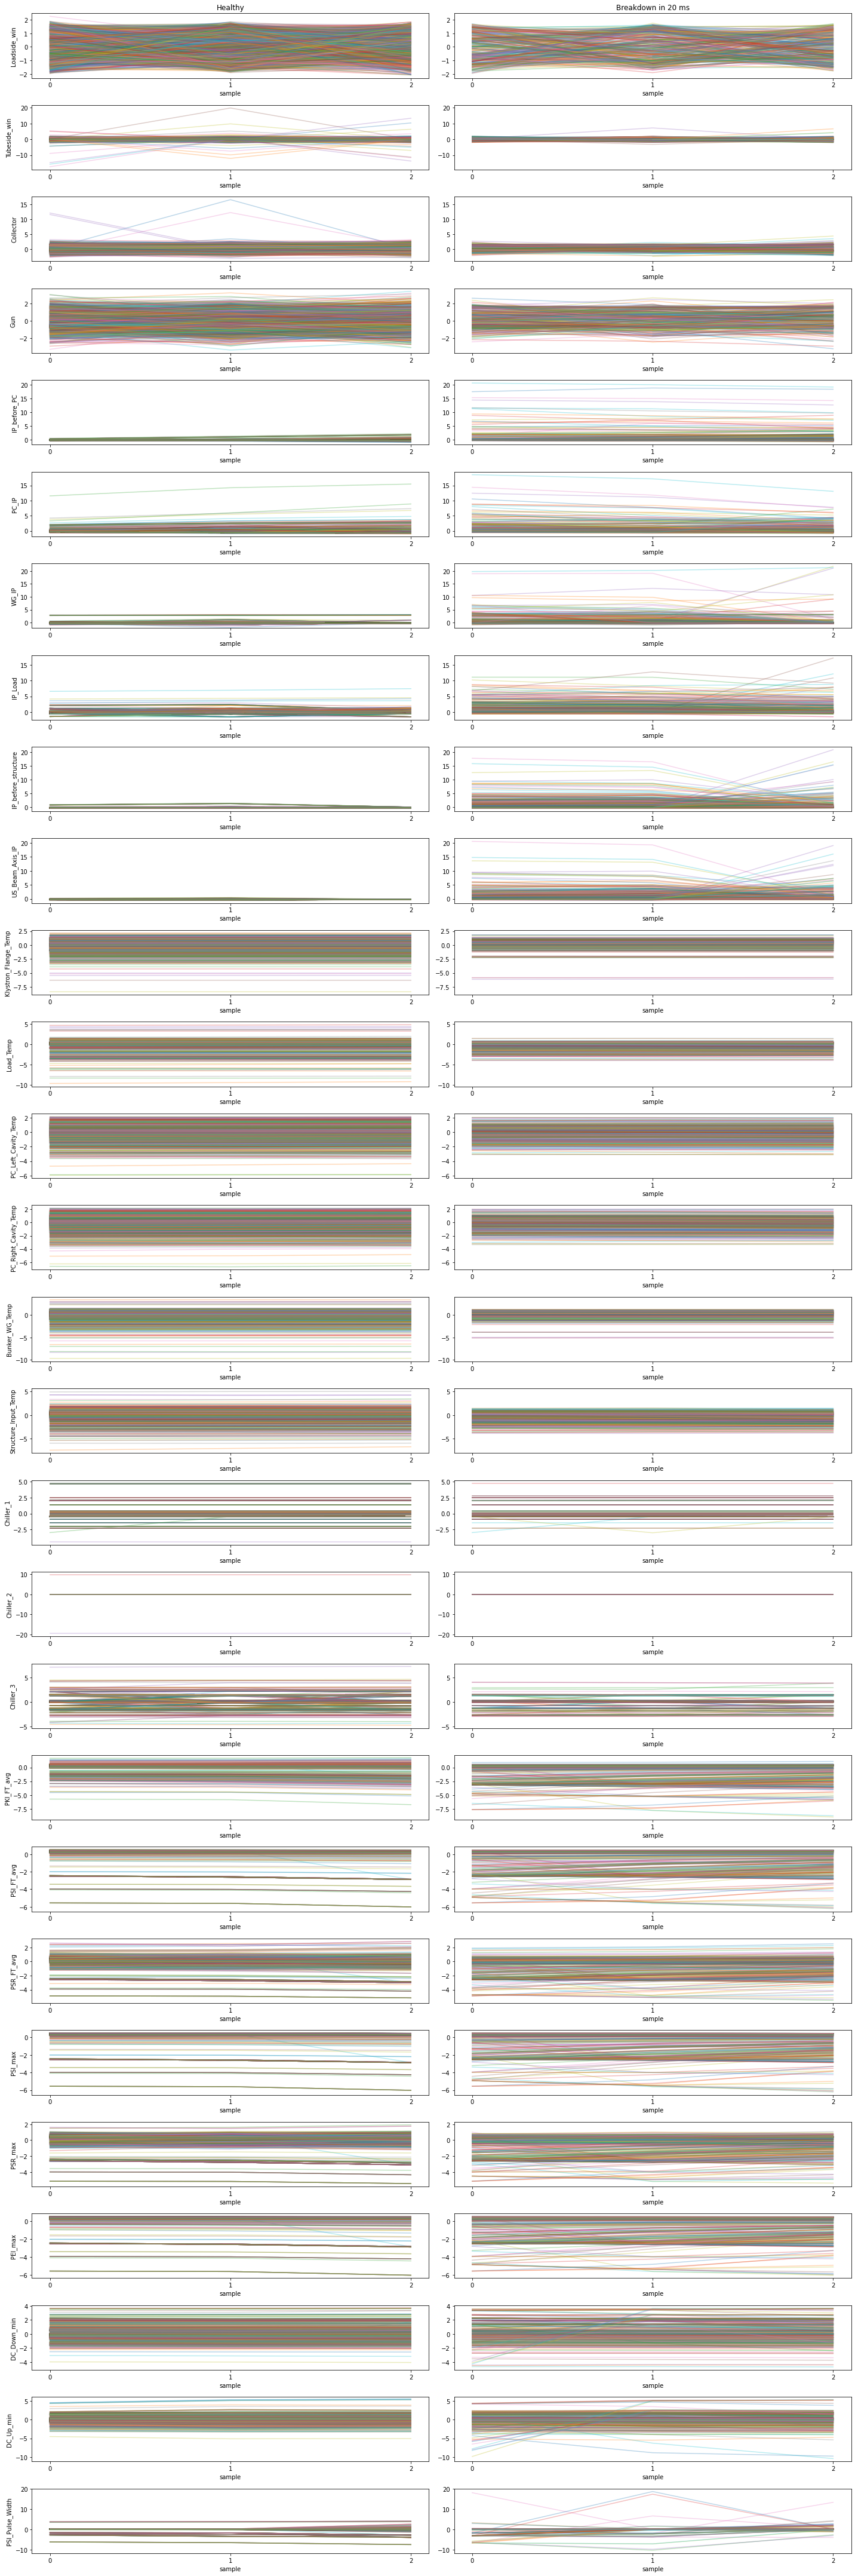

In [4]:
# Plot Dataset
n_features = len(train.X.feature)

fig, ax = plt.subplots(n_features,2, figsize=(20,60))
for i in range(n_features):
    ax[i, 0].plot(train.X[train.y.argmax(axis=1) == 0][:,:,i].values.T, alpha=0.3)
    ax[i, 0].set_xlabel("sample")
    ax[i, 0].set_ylabel(train.X.feature[i].values)
    ax[i, 0].set_xticks([0, 1, 2])
    ax[i, 1].plot(train.X[train.y.argmax(axis=1) == 1][:,:,i].values.T, alpha=0.3)
    ax[i, 1].set_xlabel("sample")
    ax[i, 1].set_xticks([0, 1, 2])
    bottom0, top0 = ax[i, 0].set_ylim()
    bottom1, top1 = ax[i, 1].set_ylim()
    ax[i, 0].set_ylim([min([bottom0, bottom1]), max([top0, top1])])
    ax[i, 1].set_ylim([min([bottom0, bottom1]), max([top0, top1])])

ax[0, 0].set_title("Healthy")
ax[0, 1].set_title("Breakdown in 20 ms")
fig.tight_layout()
plt.show()

In [5]:
# Getting data ready for machine learning
from src.utils.dataset_creator import da_to_numpy_for_ml
train_numpy, valid_numpy, test_numpy = da_to_numpy_for_ml(train, valid, test)

In [6]:
# Load hyperparameters into dictionary
hp_file = open(Path(api_dir) / "src/model/default_hyperparameters.json")
hp_dict = json.load(hp_file)

# Create model
clf = Classifier(input_shape=train_numpy.X.shape, output_directory=Path(api_dir) / "src/output", **hp_dict)

In [7]:
# Fit model to training set and validate on validation set
clf.fit_classifier(train_numpy, valid_numpy)
# load weights from an already trained model
# clf.model.load_weights(Path(api_dir) / "src/model/trained_models/trend_all_bd_20ms.hdf5")


2021-11-10 14:02:13.892436: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
136/136 [==============================] - 12s 7ms/step - loss: 0.3946 - tp: 1901.0000 - fp: 272.0000 - tn: 1901.0000 - fn: 272.0000 - accuracy: 0.8748 - precision: 0.8748 - recall: 0.8748 - auc: 0.9283 - prc: 0.9192 - val_loss: 0.4379 - val_tp: 476.0000 - val_fp: 98.0000 - val_tn: 476.0000 - val_fn: 98.0000 - val_accuracy: 0.8293 - val_precision: 0.8293 - val_recall: 0.8293 - val_auc: 0.8737 - val_prc: 0.8637
Epoch 2/100
136/136 [==============================] - 0s 3ms/step - loss: 0.2342 - tp: 2078.0000 - fp: 95.0000 - tn: 2078.0000 - fn: 95.0000 - accuracy: 0.9563 - precision: 0.9563 - recall: 0.9563 - auc: 0.9781 - prc: 0.9762 - val_loss: 0.8104 - val_tp: 358.0000 - val_fp: 216.0000 - val_tn: 358.0000 - val_fn: 216.0000 - val_accuracy: 0.6237 - val_precision: 0.6237 - val_recall: 0.6237 - val_auc: 0.6453 - val_prc: 0.6527
Epoch 3/100
136/136 [==============================] - 0s 3ms/step - loss: 0.2259 - tp: 2069.0000 - fp: 104.0000 - tn: 2069.0000 - fn: 104.0000 - acc

136/136 [==============================] - 1s 4ms/step - loss: 0.0045 - tp: 2170.0000 - fp: 3.0000 - tn: 2170.0000 - fn: 3.0000 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.4511 - val_tp: 535.0000 - val_fp: 39.0000 - val_tn: 535.0000 - val_fn: 39.0000 - val_accuracy: 0.9321 - val_precision: 0.9321 - val_recall: 0.9321 - val_auc: 0.9583 - val_prc: 0.9476
Epoch 21/100
136/136 [==============================] - 0s 3ms/step - loss: 0.0028 - tp: 2171.0000 - fp: 2.0000 - tn: 2171.0000 - fn: 2.0000 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.4611 - val_tp: 538.0000 - val_fp: 36.0000 - val_tn: 538.0000 - val_fn: 36.0000 - val_accuracy: 0.9373 - val_precision: 0.9373 - val_recall: 0.9373 - val_auc: 0.9574 - val_prc: 0.9463
Epoch 22/100
136/136 [==============================] - 0s 3ms/step - loss: 9.7143e-04 - tp: 2173.0000 - fp: 0.0000e+00 - tn: 2173.0000 - fn: 0.0000e+00 - accuracy: 1.00

136/136 [==============================] - 0s 3ms/step - loss: 9.4373e-06 - tp: 2173.0000 - fp: 0.0000e+00 - tn: 2173.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.6622 - val_tp: 538.0000 - val_fp: 36.0000 - val_tn: 538.0000 - val_fn: 36.0000 - val_accuracy: 0.9373 - val_precision: 0.9373 - val_recall: 0.9373 - val_auc: 0.9512 - val_prc: 0.9381
Epoch 40/100
136/136 [==============================] - 0s 3ms/step - loss: 8.5590e-06 - tp: 2173.0000 - fp: 0.0000e+00 - tn: 2173.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.6664 - val_tp: 538.0000 - val_fp: 36.0000 - val_tn: 538.0000 - val_fn: 36.0000 - val_accuracy: 0.9373 - val_precision: 0.9373 - val_recall: 0.9373 - val_auc: 0.9512 - val_prc: 0.9382
Epoch 41/100
136/136 [==============================] - 0s 3ms/step - loss: 7.6949e-06 - tp: 2173.0000 - fp: 0.0000e+00 - tn: 2173.0000 - fn: 0.0

Epoch 58/100
136/136 [==============================] - 0s 2ms/step - loss: 1.6545e-06 - tp: 2173.0000 - fp: 0.0000e+00 - tn: 2173.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7528 - val_tp: 538.0000 - val_fp: 36.0000 - val_tn: 538.0000 - val_fn: 36.0000 - val_accuracy: 0.9373 - val_precision: 0.9373 - val_recall: 0.9373 - val_auc: 0.9517 - val_prc: 0.9387
Epoch 59/100
136/136 [==============================] - 0s 3ms/step - loss: 1.5158e-06 - tp: 2173.0000 - fp: 0.0000e+00 - tn: 2173.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7584 - val_tp: 538.0000 - val_fp: 36.0000 - val_tn: 538.0000 - val_fn: 36.0000 - val_accuracy: 0.9373 - val_precision: 0.9373 - val_recall: 0.9373 - val_auc: 0.9517 - val_prc: 0.9387
Epoch 60/100
136/136 [==============================] - 0s 3ms/step - loss: 1.3918e-06 - tp: 2173.0000 - fp: 0.0000e+00 - tn: 2173.0

Epoch 77/100
136/136 [==============================] - 0s 3ms/step - loss: 3.4644e-07 - tp: 2173.0000 - fp: 0.0000e+00 - tn: 2173.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.8352 - val_tp: 538.0000 - val_fp: 36.0000 - val_tn: 538.0000 - val_fn: 36.0000 - val_accuracy: 0.9373 - val_precision: 0.9373 - val_recall: 0.9373 - val_auc: 0.9474 - val_prc: 0.9332
Epoch 78/100
136/136 [==============================] - 0s 3ms/step - loss: 3.2072e-07 - tp: 2173.0000 - fp: 0.0000e+00 - tn: 2173.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.8392 - val_tp: 538.0000 - val_fp: 36.0000 - val_tn: 538.0000 - val_fn: 36.0000 - val_accuracy: 0.9373 - val_precision: 0.9373 - val_recall: 0.9373 - val_auc: 0.9475 - val_prc: 0.9333
Epoch 79/100
136/136 [==============================] - 0s 3ms/step - loss: 2.9538e-07 - tp: 2173.0000 - fp: 0.0000e+00 - tn: 2173.0

Epoch 96/100
136/136 [==============================] - 0s 3ms/step - loss: 1.1456e-07 - tp: 2173.0000 - fp: 0.0000e+00 - tn: 2173.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.8900 - val_tp: 538.0000 - val_fp: 36.0000 - val_tn: 538.0000 - val_fn: 36.0000 - val_accuracy: 0.9373 - val_precision: 0.9373 - val_recall: 0.9373 - val_auc: 0.9449 - val_prc: 0.9299
Epoch 97/100
136/136 [==============================] - 0s 3ms/step - loss: 1.0868e-07 - tp: 2173.0000 - fp: 0.0000e+00 - tn: 2173.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.8947 - val_tp: 538.0000 - val_fp: 36.0000 - val_tn: 538.0000 - val_fn: 36.0000 - val_accuracy: 0.9373 - val_precision: 0.9373 - val_recall: 0.9373 - val_auc: 0.9449 - val_prc: 0.9299
Epoch 98/100
136/136 [==============================] - 0s 3ms/step - loss: 1.0262e-07 - tp: 2173.0000 - fp: 0.0000e+00 - tn: 2173.0

## Evaluate Model
To evaluate the performance of the model, the `evaluate` method can be used.

In [8]:
# eval classifier
results = clf.model.evaluate(x=test_numpy.X, y=test_numpy.y, return_dict=True)
pd.DataFrame.from_dict(results, orient='index').T

21/21 [==============================] - 0s 2ms/step - loss: 0.5697 - tp: 636.0000 - fp: 17.0000 - tn: 636.0000 - fn: 17.0000 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9797 - prc: 0.9738    


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,0.569676,636.0,17.0,636.0,17.0,0.973966,0.973966,0.973966,0.979728,0.973786


# Explanation
After training the model we now wish to explain the predictions of the model.
This can be done using explainers such as the SHAP gradient explainer.

## Make prediction
To explain a prediction we first make predictions on the test set

In [9]:
y_pred = clf.model.predict(x=test_numpy.X)

We then use `explain_samples` to explain the samples here using the SHAP graident explainer.

In [10]:
from src.model.explainer import explain_samples
from src.model.sample_explainers.gradient_shap import ShapGradientExplainer

is_correct_classification = (y_pred.argmax(axis=1) == test_numpy.y.argmax(axis=1))
ex_classification = explain_samples(explainer=ShapGradientExplainer(),
                                    model=clf.model,
                                    X_reference=train_numpy.X,
                                    X_to_explain=test_numpy.X[is_correct_classification, :, :])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


## Visualization of explanations
In order to present the sample explanation we can make a plot of the signal with a coloured overlay.
The overlay color is determined by the shap value.

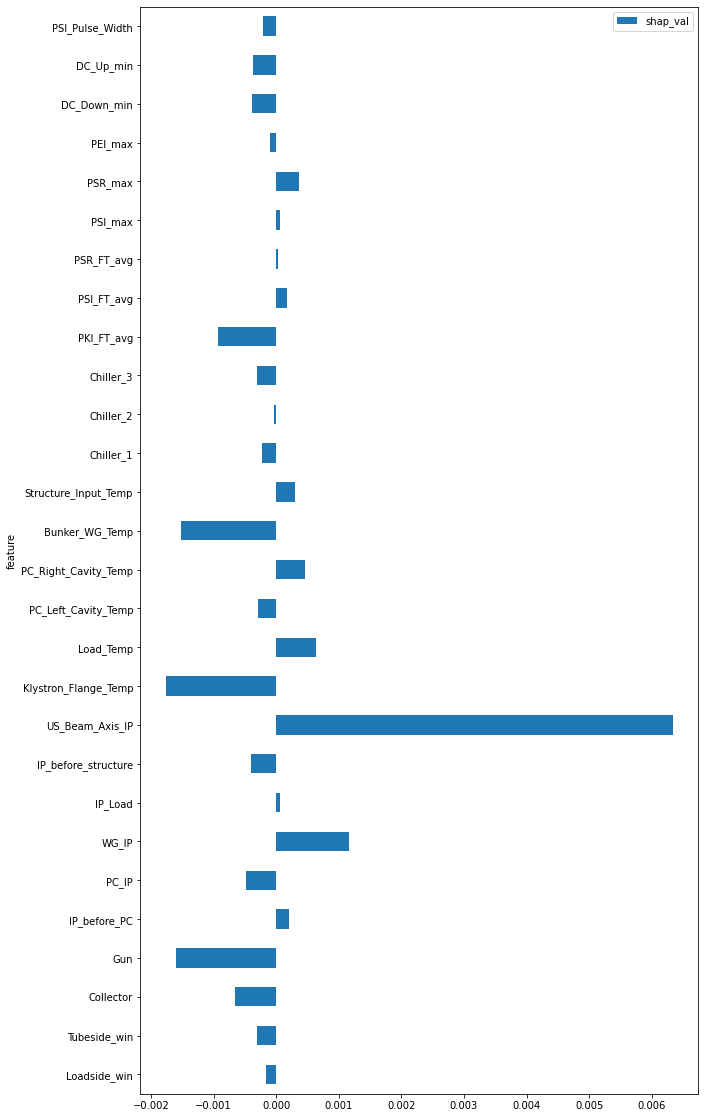

In [12]:
import numpy as np
import pandas as pd
ex_global = np.mean(np.mean(ex_classification[1], axis=0), axis=0)
df = pd.DataFrame({'feature': test.X.feature.values, 'shap_val': ex_global})
ax = df.plot.barh(x='feature', y='shap_val', figsize=(10,20))

In [ ]:
def plot_importance(X_to_explain, y_pred, explanation):
    cmap = mpl.colors.LinearSegmentedColormap.from_list('shap', [mpl.cm.cool(0), (1, 1, 1, 1), mpl.cm.cool(256)],N=256)

    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 0), :, :].mean(axis=0), linewidth=3, c="b")
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 1), :, :].mean(axis=0), linewidth=3, c="r")

    extent = [0, len(X_to_explain[0]), ax.get_ylim()[0], ax.get_ylim()[1]]
    im1 = ax.imshow(explanation[0].mean(axis=0).T, cmap=cmap, aspect="auto", alpha=0.8, extent=extent)
    cbar1 = fig.colorbar(im1, ax=ax)
    cbar1.set_label("SHAP values (relative)")

    ax.set_xlabel("samples")
    ax.set_xlabel("amplitude")
    ax.set_title("Explanations of Classifications")
    ax.legend(["Mean normal","Mean ischemia"])